In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading all CPI CSV Data
bread_csv = pd.read_csv("bread_clean.csv")

coffee_csv = pd.read_csv("coffee_clean.csv")

eggs_csv = pd.read_csv("eggs_clean.csv")

#Find aggregate CPI data, stored as a dataframe, units are percent increase
agg_cpi_df = pd.concat([bread_csv, coffee_csv, eggs_csv]).groupby(level=0).mean()
agg_cpi_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2010.0,NaN,0.915002,-2.244567,-0.197901,-4.683961,0.254174,-0.294247,2.772519,7.499659,-5.134425,6.586959,0.219582
1,2011.0,2.781238,-3.381937,4.224444,3.317551,0.728083,0.912698,1.794906,1.752091,4.000727,-2.578325,-1.194416,0.013305
2,2012.0,1.594445,-2.676211,-0.441340,1.504306,-2.340447,-0.709814,0.973077,4.131549,-0.053682,2.894264,0.964955,0.373496
3,2013.0,-1.660972,-0.609682,0.924091,-2.076525,-0.999963,0.179683,-1.739263,-1.625791,0.544076,-0.561174,-0.116537,1.212811
4,2014.0,-0.258770,0.243087,0.374597,2.974705,-1.949347,-3.949789,3.405845,0.539220,0.372965,-1.277669,-0.587794,3.129825


In [3]:
# Find inflation gap data
inflation_gap = agg_cpi_df - 2

# Fix Years being Subtracted as well
inflation_gap["Year"] = inflation_gap["Year"] + 2

# Pure data DF that doesn't have the years
inflation_data = inflation_gap.iloc[:,1:]

In [4]:
# dictionary for finding the month six months later
six_months_later = {
    "Jan": "Jul",
    "Feb": "Aug",
    "Mar": "Sep",
    "Apr": "Oct",
    "May": "Nov",
    "Jun": "Dec",
    "Jul": "Jan",
    "Aug": "Feb",
    "Sep": "Mar",
    "Oct": "Apr",
    "Nov": "May",
    "Dec": "Jun"
}

first_half_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun"]

#data frame for the difference between a time and its equivalent six months later
first_half_delta_gap_df = pd.DataFrame()

for i in range(len(first_half_months)):
    #find which two months I have to subtract
    month_one = first_half_months[i]
    month_two = six_months_later[month_one]

    #subtract and divide to get the final result
    first_half_delta_gap_df[month_one] = (inflation_gap[month_one] - inflation_gap[month_two]) / (np.abs(inflation_gap[month_one]) + 1)

second_half_delta_gap_df = pd.DataFrame()

second_half_months = ["Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for i in range(len(second_half_months)):
    month_one = second_half_months[i]
    month_two = six_months_later[month_one]

    second_half_delta_gap_df[month_one] = (inflation_gap[month_one] - inflation_gap[month_two].shift(-1)) / (np.abs(inflation_gap[month_one]) + 1)

In [5]:
# Change per unit change of interest rate in the gap to target rate of inflation rate (G)
delta_gap_df = pd.concat([first_half_delta_gap_df,second_half_delta_gap_df], axis=1)

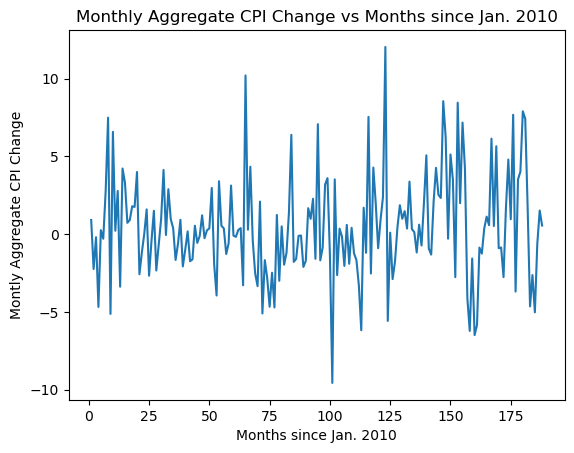

In [6]:
y = agg_cpi_df.iloc[:, 1:].to_numpy().flatten()

plt.plot(y)
plt.title("Monthly Aggregate CPI Change vs Months since Jan. 2010")
plt.xlabel("Months since Jan. 2010")
plt.ylabel("Montly Aggregate CPI Change")
plt.savefig("base_aggregate_inflation_data", dpi=300, bbox_inches="tight")
plt.show()

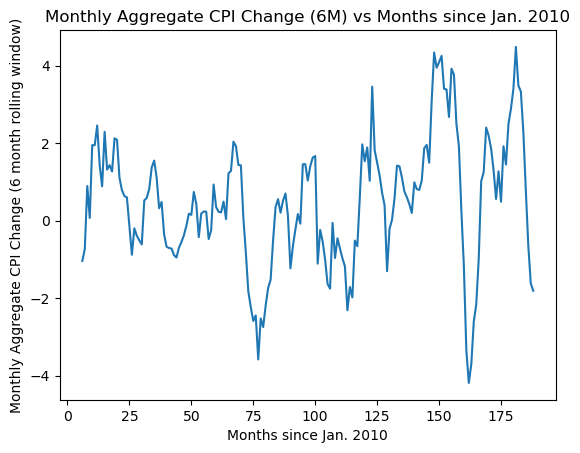

In [7]:
months = 6

rolling_averaged_agg_cpi = pd.Series(y).rolling(window=months).mean()

plt.plot(rolling_averaged_agg_cpi)
plt.title(f"Monthly Aggregate CPI Change ({months}M) vs Months since Jan. 2010")
plt.xlabel("Months since Jan. 2010")
plt.ylabel(f"Monthly Aggregate CPI Change ({months} month rolling window)")
plt.savefig(f"{months}_month_roll_aggregate_inflation_data", dpi=300, bbox_inches="tight")
plt.show()

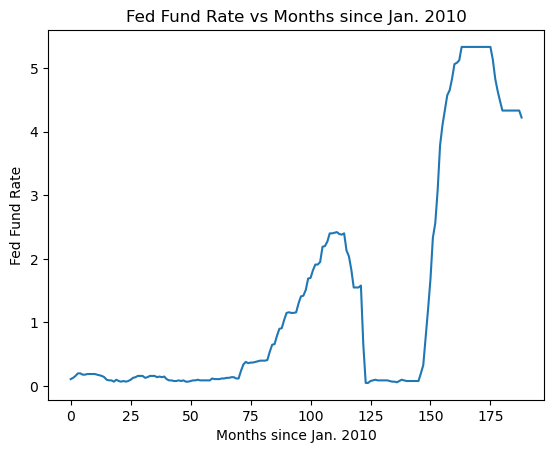

In [8]:
# Fed Fund Rate data
fed_interest_rate = pd.read_csv("FRED_Data.csv")

# Only looking at target scope
fed_interest_rate_df = fed_interest_rate[fed_interest_rate["Year"] >= 2010]

# Removes Years before graphing
plt.plot(fed_interest_rate_df.iloc[:, 1:].to_numpy().flatten())

plt.title("Fed Fund Rate vs Months since Jan. 2010")
plt.xlabel("Months since Jan. 2010")
plt.ylabel("Fed Fund Rate")
plt.savefig("fed_fund_rate_data", dpi=300, bbox_inches="tight")
plt.show()

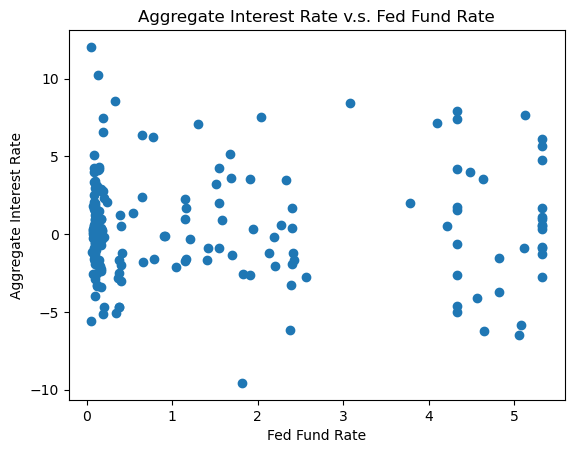

In [9]:
plt.scatter(fed_interest_rate_df.iloc[:, 1:], agg_cpi_df.iloc[:, 1:])
plt.title("Aggregate Interest Rate v.s. Fed Fund Rate")
plt.xlabel("Fed Fund Rate")
plt.ylabel("Aggregate Interest Rate")
plt.savefig("Scatterplot_of_Inflation_Rate_vs_Interest_Rate", dpi=300, bbox_inches="tight")
plt.show()

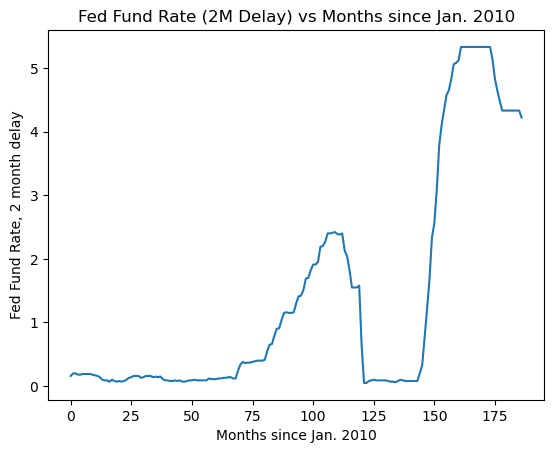

In [10]:
# AI Assisted Code
y_vals = fed_interest_rate_df.iloc[:, 1:].to_numpy().ravel()

# Shift X by two, so that we assume the Fed responds to the previous months' inflation rate.
y_shifted = np.roll(y_vals, -2)   # shift left by 2

# Last two values should be NaN, roll() moves the first two values to the end.
y_shifted[-2:] = np.nan

plt.plot(y_shifted)
plt.title("Fed Fund Rate (2M Delay) vs Months since Jan. 2010")
plt.xlabel("Months since Jan. 2010")
plt.ylabel("Fed Fund Rate, 2 month delay")
plt.savefig("2_month_delay_fed_fund_rate_data", dpi=300, bbox_inches="tight")
plt.show()

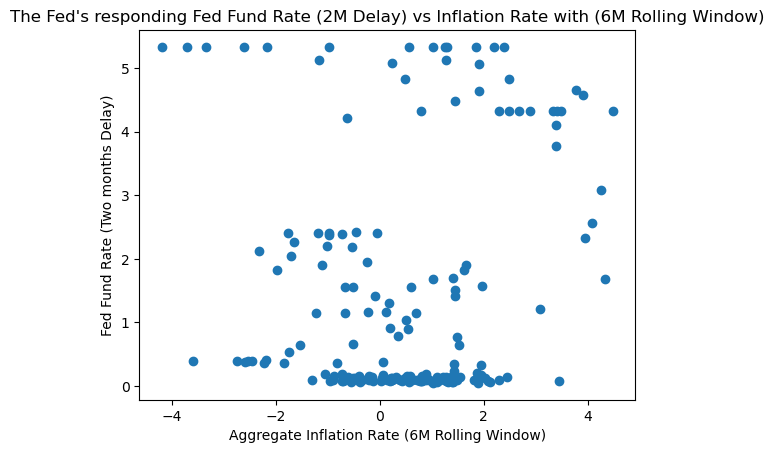

In [11]:
plt.scatter(rolling_averaged_agg_cpi, y_shifted)
plt.title("The Fed's responding Fed Fund Rate (2M Delay) vs Inflation Rate with (6M Rolling Window)")
plt.xlabel("Aggregate Inflation Rate (6M Rolling Window)")
plt.ylabel("Fed Fund Rate (Two months Delay)")
plt.savefig("Fed_Fund_Rate_as_response_to_Inflation_6_month_rolling", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
# Regression Line
# Derivation - https://docs.google.com/document/d/1kzwPJW9lz2Li3BbyLpwohsugOb9nhutLRdQrFlAZcD0/edit?usp=sharing

# AI Assisted Code
mask = ~np.isnan(rolling_averaged_agg_cpi) & ~np.isnan(y_shifted)
x = rolling_averaged_agg_cpi.to_numpy()[mask]
y = y_shifted[mask]

# Weights for each month
lambda_decay = 0.99
N = len(x)
w = lambda_decay ** (N - np.arange(N))

# Variables
wx = w * x
wy = w * y
wxx = w * x * x
wxy = w * x * y  

# Sums of Variables
W = np.sum(w)
Sx  = np.sum(wx) 
Sy  = np.sum(wy)
Sxx = np.sum(wxx)
Sxy = np.sum(wxy)

# Calculate a and b
b = (Sxy - ((Sx * Sy) / W)) / (Sxx - ((Sx*Sx) / W))
c = (Sy - b * Sx) / W

# Final Regression Line 
y_pred = b * x + c

In [13]:
# Values of b and c
print(f"b = {b}")
print(f"c = {c}")

b = 0.1525147246412545
c = 2.0746350292260236


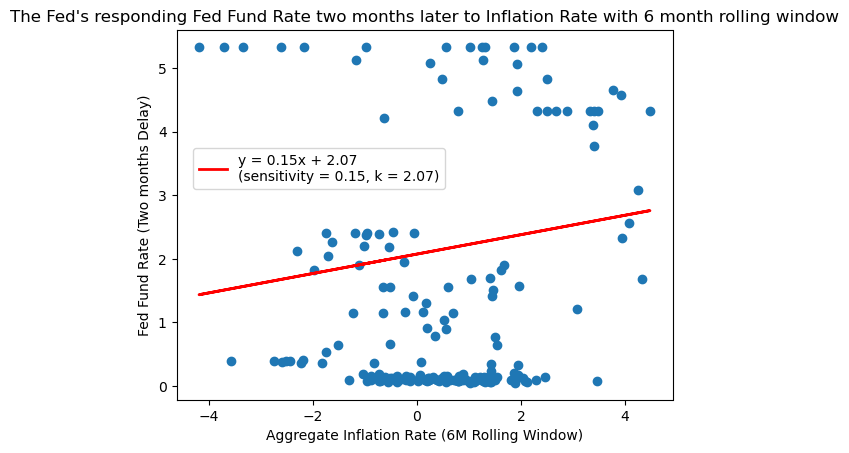

In [14]:
# Plot Regression in data
label_text = f"y = {b:.2f}x + {c:.2f}\n(sensitivity = {b:.2f}, k = {c:.2f})"
plt.plot(x, y_pred, color='red', linewidth=2, label=label_text)

# Plot Scatter
plt.scatter(rolling_averaged_agg_cpi, y_shifted)

# Graph
plt.title("The Fed's responding Fed Fund Rate two months later to Inflation Rate with 6 month rolling window")
plt.xlabel("Aggregate Inflation Rate (6M Rolling Window)")
plt.ylabel("Fed Fund Rate (Two months Delay)")

# Legend
plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.70))

# Saving picture of Graph
plt.savefig("Linear_Regression", dpi=300, bbox_inches="tight")

plt.show()

In [15]:
# Goal Alignment Metric
goal_alignment_df = 1 - np.abs(inflation_gap)/2
goal_alignment_df = goal_alignment_df.iloc[:,1:]

In [16]:
# Constants
coefficient = 4
constant_1 = 1
constant_2 = 1.1
constant_3 = 1.1

# Sensitivity Metric
S = b

# Goal Alignment Metric
A = goal_alignment_df

# Gap Metric
delta_G = delta_gap_df

# Effectiveness Metric
E = coefficient * (S ** constant_1) * (constant_2 ** delta_G) * (constant_3 ** A)
E = E.to_numpy().flatten()

In [17]:
# Read in data for Economic Damage
df_unemployment = pd.read_csv("Unemployment_Data.csv")
df_GDP = pd.read_csv("gdp_growth_wide.csv")

In [18]:
df_unemployment.head()

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino
0,Aug 2005,4.9,4.3,4.4,16.1,4.2,9.7,3.7,5.8
1,Sept 2005,5.0,4.5,4.6,15.5,4.4,9.4,4.3,6.4
2,Oct 2005,5.0,4.3,4.5,16.1,4.4,9.1,3.2,6.0
3,Nov 2005,5.0,4.3,4.6,17.0,4.3,10.6,3.6,6.1
4,Dec 2005,4.9,4.3,4.4,14.9,4.2,9.2,3.8,6.1


In [19]:
df_GDP.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1992,NaN,0.467508,1.045959,-0.080365,-0.278450,1.497064,0.122013,-0.256694,0.412087,0.538811,0.230542,0.473471
1,1993,-0.388872,0.291372,-0.086514,0.127371,0.512512,0.218073,-0.361784,0.407088,0.756541,-0.066139,1.044562,0.259033
2,1994,-0.103194,0.574631,0.507751,0.142111,0.995586,0.043877,-0.118251,0.726943,-0.419215,0.924998,-0.107531,0.993853
3,1995,-0.033728,-0.784315,0.876990,-0.576606,0.323535,1.030894,-0.576541,0.600420,0.709252,-0.310598,0.045608,0.871886
4,1996,-0.162269,0.116779,0.722272,1.237015,-0.372391,0.467959,0.488983,0.092339,0.468149,0.817678,-0.043736,-0.281502


In [20]:
# Ensure dtype is string
df_unemployment["Month"] = df_unemployment["Month"].astype(str)

# Normalize month names to consistent abbreviations
df_unemployment["Month"] = (
    df_unemployment["Month"]
        .str.replace("June", "Jun")
        .str.replace("July", "Jul")
        .str.replace("Sept", "Sep")
)

# Convert Month column to datetime
df_unemployment["Month"] = pd.to_datetime(
    df_unemployment["Month"],
    format="%b %Y",
    errors="coerce"
)

# Filter from Jan 2010 onward
df_unemployment = df_unemployment[df_unemployment["Month"] >= "2010-01-01"].copy()

# Focus on Total unemployment only
df_u = df_unemployment[["Month", "Total"]].copy()

In [21]:
df_GDP = df_GDP.melt(
    id_vars="Year",
    var_name="Month",
    value_name="Rate"
)

# Convert to datetime
df_GDP['Date'] = pd.to_datetime(
    df_GDP['Year'].astype(str) + df_GDP['Month'],
    format='%Y%b'
)

# Sort by date
df_GDP = df_GDP.sort_values('Date')

# Filter from Jan 2010 onward 
df_GDP = df_GDP[df_GDP['Date'] >= "2010-01-01"]

# Set Date as index
df_GDP = df_GDP.set_index('Date')

# Last 4 months not needed
df_GDP = df_GDP.head(len(df_GDP) - 4)

In [22]:
# Filter values of unemployment, GDP, and dates
u_clean = df_u["Total"].values
g_clean = df_GDP["Rate"].values
dates_clean = df_GDP.index.values

# Constants
h = 6
a = 0.3
b = 0.5

# Compute differences for change in unemployment and GDP
delta_u = u_clean[h:] - u_clean[:-h]
delta_g = g_clean[h:] - g_clean[:-h]

# Apply max to disregard positive impacts on the economy (inc in GDP or dec in unemployment)
# Damage metric only punishes negative effects
delta_u_pos = np.maximum(0, delta_u)
delta_g_pos = np.maximum(0, delta_g)

# Compute economic damage metric
U = a * delta_u_pos + b * delta_g_pos

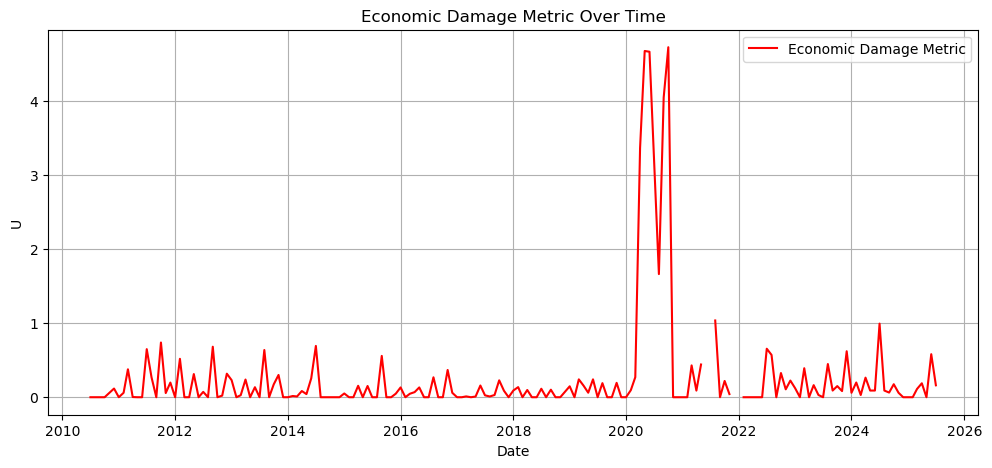

In [23]:
# Economic Damage Metric Graphed
plt.figure(figsize=(12,5))
plt.plot(dates_clean[h:], U, color='red', label='Economic Damage Metric')
plt.title("Economic Damage Metric Over Time")
plt.xlabel("Date")
plt.ylabel("U")
plt.grid(True)
plt.legend()
plt.savefig("economic_damage_graph", dpi=300, bbox_inches="tight")
plt.show()

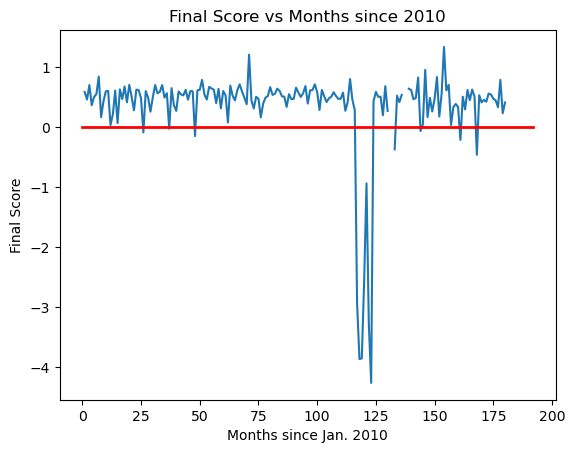

In [24]:
# Add NaNs to the end of the U array, aligns with the length of months since 2010. 
U = np.append(U, np.full(10, np.nan))

# Final Metric
final_metric = E - U

# Graph Final Metric
plt.plot(final_metric)
plt.plot(np.linspace(0, 192, 500), 0*np.linspace(0, 192, 500), color='red', linewidth=2)
plt.title("Final Score vs Months since 2010")
plt.xlabel("Months since Jan. 2010")
plt.ylabel("Final Score")
plt.savefig("final_score_graph", dpi=300, bbox_inches="tight")
plt.show()